<a href="https://colab.research.google.com/github/Marquezdan/Trabalho_3_ML/blob/main/Exemplo_completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

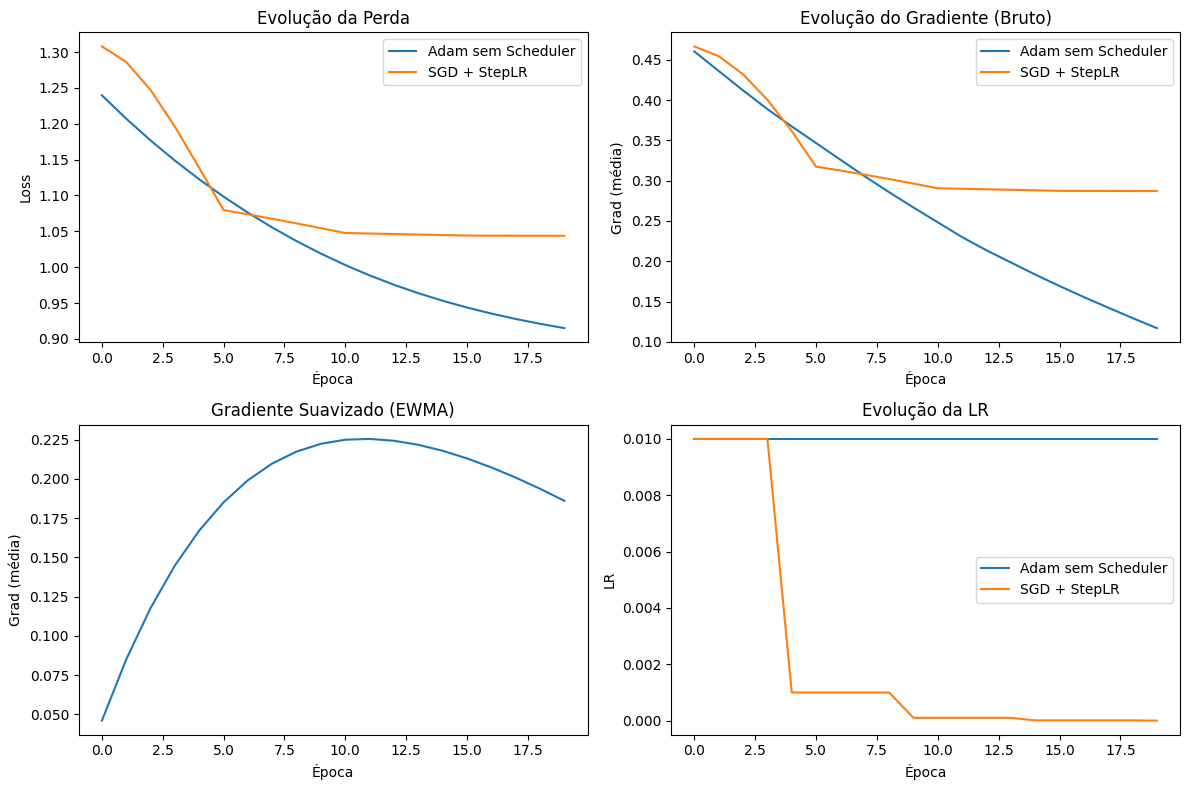

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# =====================================
# 1. Dados Sintéticos
# =====================================
# Exemplo de 100 amostras, 10 features, 1 saída
X = torch.randn(100, 10)
y = torch.randn(100, 1)

# =====================================
# 2. Modelo (Linear Simples)
# =====================================
class SimpleModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# =====================================
# 3. EWMA (Média Móvel Exponencial)
# =====================================
def compute_ewma(values, beta=0.9):
    """
    Aplica EWMA para suavizar uma lista de valores.
    """
    ewma_vals = []
    s_t = 0.0
    for v in values:
        s_t = beta * s_t + (1 - beta) * v
        ewma_vals.append(s_t)
    return ewma_vals

# =====================================
# 4. Função de Treino Unificada
# =====================================
def train_experiment(optimizer_type='adam',
                     use_scheduler=False,
                     use_ewma=False,
                     beta_ewma=0.9,
                     lr=0.01,
                     num_epochs=20):
    """
    Treina um modelo linear simples em dados sintéticos, podendo usar:
    - optimizer_type: 'adam' ou 'sgd'
    - use_scheduler: True ou False (aplica StepLR)
    - use_ewma: True ou False (suaviza gradientes coletados)
    - beta_ewma: fator de decaimento da EWMA
    - lr: learning rate inicial
    - num_epochs: número de épocas de treino

    Retorna dicionário com históricos de perda, gradientes (brutos e suavizados), LR e o modelo treinado.
    """
    # 4.1 - Instanciando modelo, critério e otimizador
    model = SimpleModel(input_dim=10, output_dim=1)
    criterion = nn.MSELoss()

    if optimizer_type.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:  # 'sgd' ou variantes
        # Exemplo: SGD com momentum=0.9 (poderia colocar nesterov=True se quiser)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # 4.2 - (Opcional) Scheduler: StepLR
    #      Reduz LR a cada 5 épocas por fator 0.1
    scheduler = None
    if use_scheduler:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # 4.3 - Estruturas para armazenar histórico
    loss_history = []
    grad_history = []
    lr_history = []

    # 4.4 - Loop de Treinamento
    for epoch in range(num_epochs):
        # Forward
        preds = model(X)
        loss = criterion(preds, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()

        # Coletando gradiente médio de todos os parâmetros
        total_grad = 0.0
        count = 0
        for param in model.parameters():
            if param.grad is not None:
                total_grad += param.grad.abs().mean().item()
                count += 1
        avg_grad = total_grad / count if count > 0 else 0.0
        grad_history.append(avg_grad)

        # Atualiza parâmetros
        optimizer.step()

        # Atualiza scheduler após .step() (no final de cada epoch)
        if scheduler is not None:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
        else:
            current_lr = optimizer.param_groups[0]['lr']

        # Guarda métricas
        loss_history.append(loss.item())
        lr_history.append(current_lr)

        # Exemplo de logging simples:
        # print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f} - Grad: {avg_grad:.4f} - LR: {current_lr}")

    # 4.5 - Aplica EWMA nos gradientes, se desejado
    grad_ewma_history = []
    if use_ewma:
        grad_ewma_history = compute_ewma(grad_history, beta=beta_ewma)

    return {
        'model': model,
        'loss_history': loss_history,
        'grad_history': grad_history,
        'grad_ewma_history': grad_ewma_history,
        'lr_history': lr_history
    }

# =====================================
# 5. Execução - "Putting It All Together"
# =====================================
# Exemplos de execução, comparando diferentes configurações

# 5.1 - Adam sem scheduler, com EWMA
results_adam = train_experiment(
    optimizer_type='adam',
    use_scheduler=False,
    use_ewma=True,
    beta_ewma=0.9,
    lr=0.01,
    num_epochs=20
)

# 5.2 - SGD com scheduler, sem EWMA
results_sgd_sched = train_experiment(
    optimizer_type='sgd',
    use_scheduler=True,
    use_ewma=False,
    lr=0.01,
    num_epochs=20
)

# =====================================
# 6. Plotando Resultados
# =====================================
fig, axes = plt.subplots(2, 2, figsize=(12,8))

# 6.1 - Loss
axes[0,0].plot(results_adam['loss_history'], label="Adam sem Scheduler")
axes[0,0].plot(results_sgd_sched['loss_history'], label="SGD + StepLR")
axes[0,0].set_title("Evolução da Perda")
axes[0,0].set_xlabel("Época")
axes[0,0].set_ylabel("Loss")
axes[0,0].legend()

# 6.2 - Gradiente Bruto
axes[0,1].plot(results_adam['grad_history'], label="Adam sem Scheduler")
axes[0,1].plot(results_sgd_sched['grad_history'], label="SGD + StepLR")
axes[0,1].set_title("Evolução do Gradiente (Bruto)")
axes[0,1].set_xlabel("Época")
axes[0,1].set_ylabel("Grad (média)")
axes[0,1].legend()

# 6.3 - Gradiente Suavizado (EWMA)
# Só faz sentido plotar se tiver EWMA (no nosso caso, Adam sem scheduler)
if results_adam['grad_ewma_history']:
    axes[1,0].plot(results_adam['grad_ewma_history'], label="Adam - Grad EWMA")
axes[1,0].set_title("Gradiente Suavizado (EWMA)")
axes[1,0].set_xlabel("Época")
axes[1,0].set_ylabel("Grad (média)")

# 6.4 - Evolução da Learning Rate
axes[1,1].plot(results_adam['lr_history'], label="Adam sem Scheduler")
axes[1,1].plot(results_sgd_sched['lr_history'], label="SGD + StepLR")
axes[1,1].set_title("Evolução da LR")
axes[1,1].set_xlabel("Época")
axes[1,1].set_ylabel("LR")
axes[1,1].legend()

plt.tight_layout()
plt.show()
